该笔记本介绍了一些处理回归问题的技术。

* 均方误差（MSE）是用于回归问题的常见损失函数（不同的损失函数用于分类问题）。
* 同样，用于回归的评估指标也不同于分类。常见的回归指标是平均绝对误差（MAE）。
* 当数字输入数据要素的值具有不同范围时，每个要素应独立缩放到相同范围。
* 如果没有太多训练数据，一种技术是选择一个隐藏层很少的小型网络，以避免过度拟合。
* 提前停止是防止过度拟合的有用技术。

在回归问题中，我们旨在预测连续值的输出，例如价格或概率。将此与分类问题进行对比，在分类问题中，我们旨在从类别列表中选择一个类别（例如，在图片包含苹果或橙子的情况下，可以识别图片中包含哪种水果）。

这款笔记本电脑使用经典的Auto MPG数据集，并建立了一个模型来预测1970年代末和1980年代初汽车的燃油效率。为此，我们将为模型提供该时间段内许多汽车的描述。此描述包括以下属性：气缸，排量，马力和重量。

In [3]:
# Use seaborn for pairplot
# .-q, --quiet 最少的输出.
!pip install -q seaborn 

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


## 获取数据集

In [5]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 12us/step


'C:\\Users\\sha\\.keras\\datasets\\auto-mpg.data'

通过pandas导入

In [6]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


清除含有空值的数据

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
dataset = dataset.dropna()

对 `Origin` 使用one-hot编码

In [9]:
origin = dataset.pop('Origin')

In [10]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


切分数据集

In [11]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

检查数据的联合分布

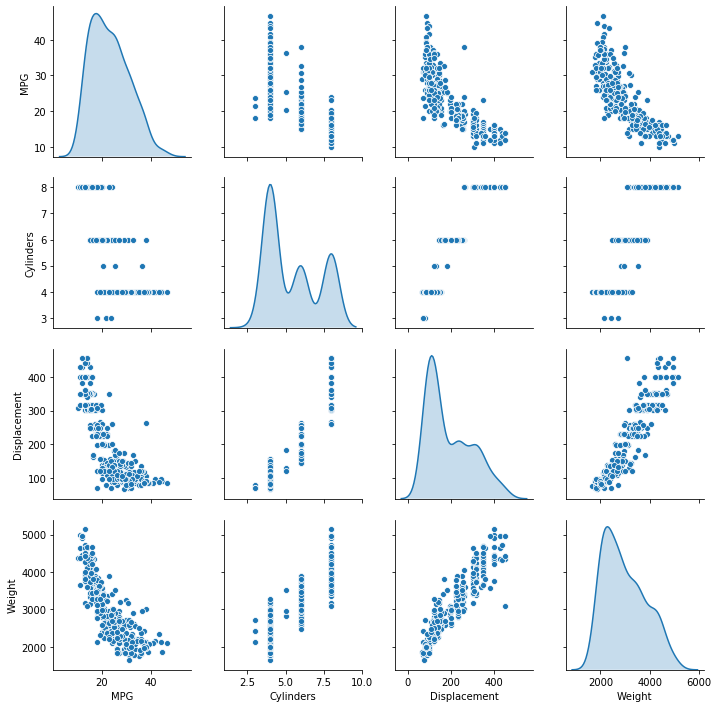

In [12]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

同时查看整体信息

In [13]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


将目标值和与特征分开

In [14]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

做归一化

In [15]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

构建一个简单的模型

In [16]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [18]:
model = build_model()

检查模型

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


测试模型

In [20]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.02408807],
       [ 0.13089907],
       [ 0.12720889],
       [-0.04422049],
       [ 0.11872122],
       [-0.10781128],
       [ 0.131292  ],
       [ 0.06789562],
       [ 0.0328142 ],
       [ 0.09068947]], dtype=float32)

训练模型

In [23]:
# 定义打印输出的回调函数
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

In [21]:


history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

使用history中的数据来可视化训练信息

In [22]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.571121,1.071150,2.571121,10.325864,2.484506,10.325864,995
996,2.342763,1.004038,2.342762,11.075355,2.517948,11.075356,996
997,2.380891,1.006623,2.380892,10.988687,2.527160,10.988688,997
998,2.580704,1.084201,2.580704,11.350402,2.563159,11.350402,998
999,2.332255,0.987122,2.332255,10.641817,2.509546,10.641817,999


可视化损失

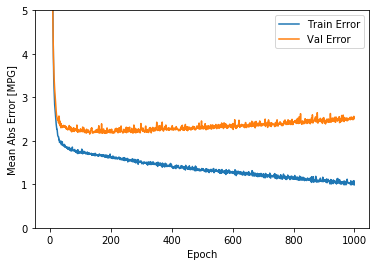

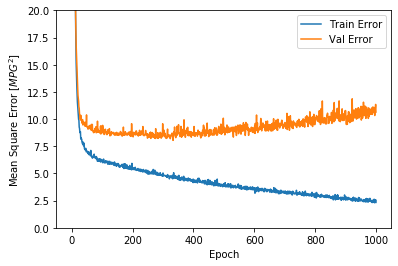

In [23]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()


plot_history(history)

可以看到 训练过程中显然过拟合了

下面让我们应用提前停止，并可视化损失

In [24]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


..................................................

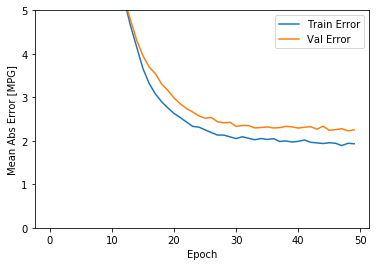

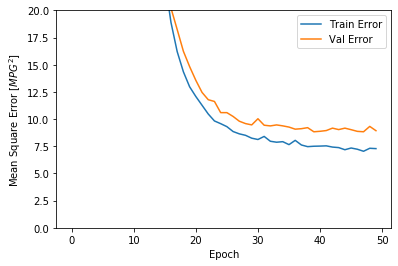

In [24]:
model = build_model()



history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

验证模型

In [25]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 6.5269 - mae: 1.9484 - mse: 6.5269
Testing set Mean Abs Error:  1.95 MPG


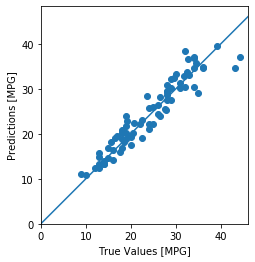

In [26]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

打印预测和实际的分布

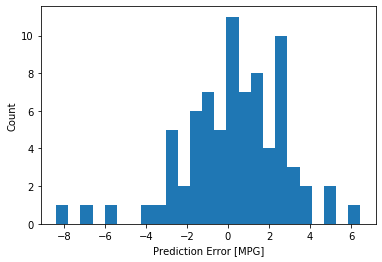

In [27]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

打印错误分布

# 自己尝试

In [29]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, input_shape=[len(train_dataset.keys())]),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(0.5),
        layers.Dense(64),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(0.5),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [30]:
model = build_model()

检查模型

In [31]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                640       
_________________________________________________________________
batch_normalization_6 (Batch (None, 64)                256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 64)               

训练模型,应用提前停止，并可视化损失

In [32]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])



..........................................................................................

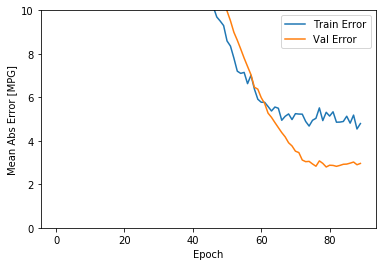

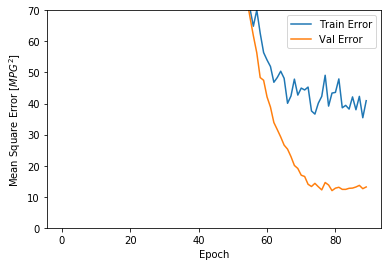

In [33]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0,10])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.ylim([0,70])
    plt.legend()
    plt.show()

plot_history(history)

验证模型

In [34]:
# 78/78 - 0s - loss: 5.6738 - mae: 1.8765 - mse: 5.6738
# Testing set Mean Abs Error:  1.88 MPG
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 10.8038 - mae: 2.4943 - mse: 10.8038
Testing set Mean Abs Error:  2.49 MPG


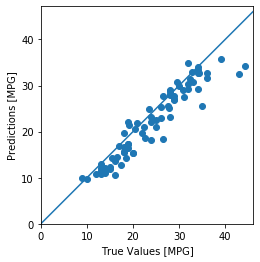

In [35]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

打印预测和实际的分布

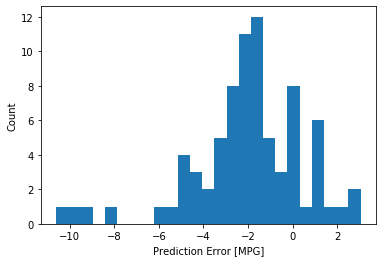

In [36]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

打印错误分布